In [1]:
from sympy import *
from sympy.parsing.sympy_parser import parse_expr
from sympy.solvers import solve
from sympy.printing.printer import Printer

Printer.set_global_settings(num_columns=2000)
precision = 5

In [38]:
def calTrusses(trussesElements, constraints, forces, A, E):
    f = {}
    us = set()
    for e, i, j, l, angle in trussesElements:
        f[Symbol('f' + str(i) + 'x')] = 0
        f[Symbol('f' + str(i) + 'y')] = 0
        f[Symbol('f' + str(j) + 'x')] = 0
        f[Symbol('f' + str(j) + 'y')] = 0
        
        us.add(i)
        us.add(j)
        
    emptyF = f.copy()
    us = [Symbol('u' + str(u) + p) for u in list(us) for p in ['x', 'y']]
    
    for e, i, j, l, angle in trussesElements:
        angle = rad(angle)
        k = N(A * E / l, precision)
        K = UnevaluatedExpr(k) * UnevaluatedExpr(N(Matrix([
            [cos(angle)**2, sin(angle)*cos(angle), -cos(angle)**2, -sin(angle)*cos(angle)],
            [sin(angle)*cos(angle), sin(angle)**2, -sin(angle)*cos(angle), -sin(angle)**2],
            [-cos(angle)**2, -sin(angle)*cos(angle), cos(angle)**2, sin(angle)*cos(angle)],
            [-sin(angle)*cos(angle), -sin(angle)**2, sin(angle)*cos(angle), sin(angle)**2],
        ]),precision))
        
        u = Matrix([
            [Symbol("u" + str(i) + "x")],
            [Symbol("u" + str(i) + "y")],
            [Symbol("u" + str(j) + "x")],
            [Symbol("u" + str(j) + "y")],
        ])
        
        pprint(Eq(Symbol('K') ** Symbol('(' + str(e) + ')'),(K, u)))
        print()
        
        Ku = N(K.doit() * u, precision)
        
        tempF = emptyF.copy()
        tempF[Symbol('f' + str(i) + 'x')] += Ku[0]
        tempF[Symbol('f' + str(i) + "y")] += Ku[1]
        tempF[Symbol('f' + str(j) + "x")] += Ku[2]
        tempF[Symbol('f' + str(j) + "y")] += Ku[3]
        
        pprint(Eq(Symbol('K')**Symbol('(' + str(e) + 'G)'),(linear_eq_to_matrix([v - k for k, v in tempF.items()], us)[0],Matrix(us))))
        print()
        print()
        
        f[Symbol('f' + str(i) + 'x')] += Ku[0]
        f[Symbol('f' + str(i) + "y")] += Ku[1]
        f[Symbol('f' + str(j) + "x")] += Ku[2]
        f[Symbol('f' + str(j) + "y")] += Ku[3]
        
    constraints = {Symbol(k):Symbol(v) for k, v in constraints.items()}
    forces = {Symbol(k): v for k, v in forces.items()}
    pprint(linear_eq_to_matrix([(v - k).subs({k:forces[k]}) if k in forces else ((v - k).subs({k:0}) if k not in constraints else constraints[k]) for k, v in f.items()], us))
    
    exprs = [(v - k).subs({k:0,**forces,**{u:0 for u in constraints.values()}}) for k, v in f.items() if k not in list(constraints.keys())]
    U = [u for u in us if u not in list(constraints.values())]
    A, y = linear_eq_to_matrix(exprs, U)
    pprint((A, y))
    
    for i in range(0, A.shape[0]):
        Aii = A[i, i];
        for j in reversed(range(i + 1, A.shape[0])):
            if A[j, i] == 0:
                continue
            print("(Eq" + str(j+1) + ")-(" +
                  str(A[j,i]/A[i,i]) + ")(Eq" + str(i+1) + "):")
            y[j] = y[j] - y[i]*A[j,i]/A[i,i]
            for k in reversed(range(i, A.shape[1])):
                A[j, k] = A[j, k] - A[i, k]*A[j,i]/A[i,i]
            A[j,i] = 0
            pprint((A, y))
            print('\n\n')
    
    pprint(Eq(Matrix(U), A.inv() * y))

In [39]:
calTrusses([
#   (e, i, j, l,    angle),
    (1, 1, 2, 36,   0),
    (2, 2, 3, 50.9, 135),
    (3, 3, 4, 36,   0),
    (4, 2, 4, 36,   90),
    (5, 2, 5, 50.9, 45),
    (6, 4, 5, 36,   0),
], {
    "f1x": "u1x",
    "f1y": "u1y",
    "f3x": "u3x",
    "f3y": "u3y",
}, {
    "f4y": -500,
    "f5y": -500,
}, 8, 1.9e6)

       ⎛          ⎡1.0   0  -1.0  0⎤  ⎡u1x⎤⎞
       ⎜          ⎢                ⎥  ⎢   ⎥⎟
       ⎜          ⎢ 0    0   0    0⎥  ⎢u1y⎥⎟
K⁽¹⁾ = ⎜4.2222e+5⋅⎢                ⎥, ⎢   ⎥⎟
       ⎜          ⎢-1.0  0  1.0   0⎥  ⎢u2x⎥⎟
       ⎜          ⎢                ⎥  ⎢   ⎥⎟
       ⎝          ⎣ 0    0   0    0⎦  ⎣u2y⎦⎠

          ⎛⎡4.2222e+5   0  -4.2222e+5  0  0  0  0  0  0  0⎤  ⎡u1x⎤⎞
          ⎜⎢                                              ⎥  ⎢   ⎥⎟
          ⎜⎢    0       0      0       0  0  0  0  0  0  0⎥  ⎢u1y⎥⎟
          ⎜⎢                                              ⎥  ⎢   ⎥⎟
          ⎜⎢-4.2222e+5  0  4.2222e+5   0  0  0  0  0  0  0⎥  ⎢u2x⎥⎟
          ⎜⎢                                              ⎥  ⎢   ⎥⎟
          ⎜⎢    0       0      0       0  0  0  0  0  0  0⎥  ⎢u2y⎥⎟
          ⎜⎢                                              ⎥  ⎢   ⎥⎟
          ⎜⎢    0       0      0       0  0  0  0  0  0  0⎥  ⎢u3x⎥⎟
K__(1G) = ⎜⎢                                              ⎥, ⎢   ⎥⎟
    

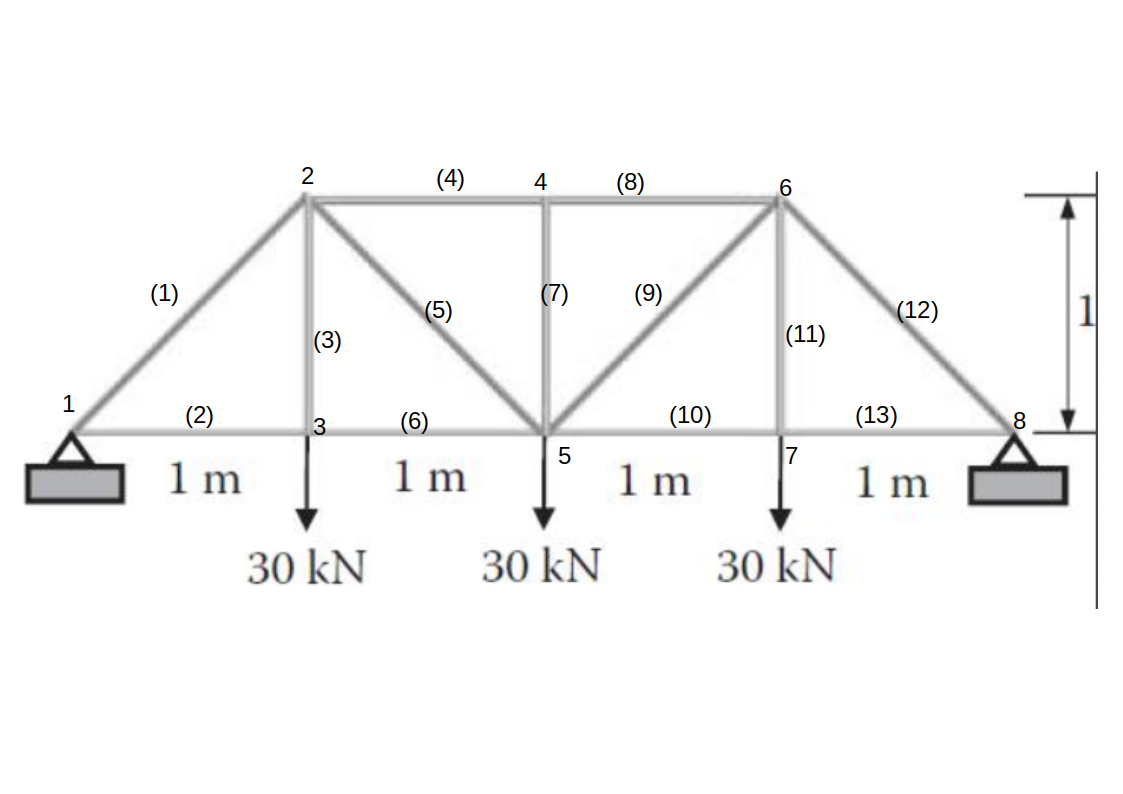

In [40]:
calTrusses([
#   (e, i, j, l,    angle),
    (1,  1, 2, sqrt(2), 45),
    (2,  1, 3, 1,       0),
    (3,  2, 3, 1,       90),
    (4,  2, 4, 1,       0),
    (5,  2, 5, sqrt(2), 135),
    (6,  3, 5, 1,       0),
    (7,  4, 5, 1,       90),
    (8,  4, 6, 1,       0),
    (9,  5, 6, sqrt(2), 45),
    (10, 5, 7, 1,       0),
    (11, 6, 7, 1,       90),
    (12, 6, 8, sqrt(2), -45),
    (13, 7, 8, 1,       0),
], {
    "f1x": "u1x",
    "f1y": "u1y",
    "f8x": "u8x",
    "f8y": "u8y",
}, {
    "f3y": -30e3,
    "f5y": -30e3,
    "f7y": -30e3,
}, 8, 1.9e6)

       ⎛          ⎡0.5   0.5   -0.5  -0.5⎤  ⎡u1x⎤⎞
       ⎜          ⎢                      ⎥  ⎢   ⎥⎟
       ⎜          ⎢0.5   0.5   -0.5  -0.5⎥  ⎢u1y⎥⎟
K⁽¹⁾ = ⎜1.0748e+7⋅⎢                      ⎥, ⎢   ⎥⎟
       ⎜          ⎢-0.5  -0.5  0.5   0.5 ⎥  ⎢u2x⎥⎟
       ⎜          ⎢                      ⎥  ⎢   ⎥⎟
       ⎝          ⎣-0.5  -0.5  0.5   0.5 ⎦  ⎣u2y⎦⎠

          ⎛⎡5.374e+6   5.374e+6   -5.374e+6  -5.374e+6  0  0  0  0  0  0  0  0
          ⎜⎢                                                                  
          ⎜⎢5.374e+6   5.374e+6   -5.374e+6  -5.374e+6  0  0  0  0  0  0  0  0
          ⎜⎢                                                                  
          ⎜⎢-5.374e+6  -5.374e+6  5.374e+6   5.374e+6   0  0  0  0  0  0  0  0
          ⎜⎢                                                                  
          ⎜⎢-5.374e+6  -5.374e+6  5.374e+6   5.374e+6   0  0  0  0  0  0  0  0
          ⎜⎢                                                                  
          

          ⎛⎡0  0  0  0  0  0  0  0      0          0          0          0    
          ⎜⎢                                                                  
          ⎜⎢0  0  0  0  0  0  0  0      0          0          0          0    
          ⎜⎢                                                                  
          ⎜⎢0  0  0  0  0  0  0  0      0          0          0          0    
          ⎜⎢                                                                  
          ⎜⎢0  0  0  0  0  0  0  0      0          0          0          0    
          ⎜⎢                                                                  
          ⎜⎢0  0  0  0  0  0  0  0      0          0          0          0    
          ⎜⎢                                                                  
          ⎜⎢0  0  0  0  0  0  0  0      0          0          0          0    
          ⎜⎢                                                                  
          ⎜⎢0  0  0  0  0  0  0  0      0          0

⎛⎡2.5948e+7      0         0          0      -1.52e+7      0      -5.374e+6  5
⎜⎢                                                                            
⎜⎢    0      2.5948e+7     0      -1.52e+7       0         0      5.374e+6   -
⎜⎢                                                                            
⎜⎢    0          0      3.04e+7       0          0         0      -1.52e+7    
⎜⎢                                                                            
⎜⎢    0      -1.52e+7      0       1.52e+7       0         0          0       
⎜⎢                                                                            
⎜⎢    0          0         0          0      2.1496e+7     0      -3.148e+6  3
⎜⎢                                                                            
⎜⎢    0          0         0          0          0      1.52e+7       0      -
⎜⎢                                                                            
⎜⎢    0      5.374e+6   -1.52e+7      0      -3.148e

⎡u2x⎤   ⎡0.00394734935208292 ⎤
⎢   ⎥   ⎢                    ⎥
⎢u2y⎥   ⎢-0.0123209522847507 ⎥
⎢   ⎥   ⎢                    ⎥
⎢u3x⎥   ⎢-3.86778126843998e-9⎥
⎢   ⎥   ⎢                    ⎥
⎢u3y⎥   ⎢-0.0142946218856296 ⎥
⎢   ⎥   ⎢                    ⎥
⎢u4x⎥   ⎢-3.75907815270381e-9⎥
⎢   ⎥   ⎢                    ⎥
⎢u4y⎥   ⎢-0.0190594927627804 ⎥
⎢   ⎥ = ⎢                    ⎥
⎢u5x⎥   ⎢  -6.5685546054e-9  ⎥
⎢   ⎥   ⎢                    ⎥
⎢u5y⎥   ⎢-0.0190594905652542 ⎥
⎢   ⎥   ⎢                    ⎥
⎢u6x⎥   ⎢-0.00394736234376924⎥
⎢   ⎥   ⎢                    ⎥
⎢u6y⎥   ⎢-0.0123209790567682 ⎥
⎢   ⎥   ⎢                    ⎥
⎢u7x⎥   ⎢-4.35176946117066e-9⎥
⎢   ⎥   ⎢                    ⎥
⎣u7y⎦   ⎣-0.0142946496357955 ⎦


In [41]:
calTrusses([
#   (e, i, j, l,    angle),
    (1,  1, 2, sqrt(2), 45),
    (2,  1, 3, 1,       0),
    (3,  2, 3, 1,       90),
    (4,  2, 4, 1,       0),
    (5,  2, 5, sqrt(2), -45),
    (6,  3, 5, 1,       0),
    (7,  4, 5, 1,       90),
    (8,  4, 6, 1,       0),
    (9,  5, 6, sqrt(2), 45),
    (10, 5, 7, 1,       0),
    (11, 6, 7, 1,       90),
    (12, 6, 8, sqrt(2), -45),
    (13, 7, 8, 1,       0),
], {
    "f1x": "u1x",
    "f1y": "u1y",
    "f8x": "u8x",
    "f8y": "u8y",
}, {
    "f3y": -30e3,
    "f5y": -30e3,
    "f7y": -30e3,
}, 8, 1.9e6)

       ⎛          ⎡0.5   0.5   -0.5  -0.5⎤  ⎡u1x⎤⎞
       ⎜          ⎢                      ⎥  ⎢   ⎥⎟
       ⎜          ⎢0.5   0.5   -0.5  -0.5⎥  ⎢u1y⎥⎟
K⁽¹⁾ = ⎜1.0748e+7⋅⎢                      ⎥, ⎢   ⎥⎟
       ⎜          ⎢-0.5  -0.5  0.5   0.5 ⎥  ⎢u2x⎥⎟
       ⎜          ⎢                      ⎥  ⎢   ⎥⎟
       ⎝          ⎣-0.5  -0.5  0.5   0.5 ⎦  ⎣u2y⎦⎠

          ⎛⎡5.374e+6   5.374e+6   -5.374e+6  -5.374e+6  0  0  0  0  0  0  0  0
          ⎜⎢                                                                  
          ⎜⎢5.374e+6   5.374e+6   -5.374e+6  -5.374e+6  0  0  0  0  0  0  0  0
          ⎜⎢                                                                  
          ⎜⎢-5.374e+6  -5.374e+6  5.374e+6   5.374e+6   0  0  0  0  0  0  0  0
          ⎜⎢                                                                  
          ⎜⎢-5.374e+6  -5.374e+6  5.374e+6   5.374e+6   0  0  0  0  0  0  0  0
          ⎜⎢                                                                  
          

          ⎛⎡0  0  0  0  0  0  0     0      0     0      0  0  0  0  0  0⎤  ⎡u1
          ⎜⎢                                                            ⎥  ⎢  
          ⎜⎢0  0  0  0  0  0  0     0      0     0      0  0  0  0  0  0⎥  ⎢u1
          ⎜⎢                                                            ⎥  ⎢  
          ⎜⎢0  0  0  0  0  0  0     0      0     0      0  0  0  0  0  0⎥  ⎢u2
          ⎜⎢                                                            ⎥  ⎢  
          ⎜⎢0  0  0  0  0  0  0     0      0     0      0  0  0  0  0  0⎥  ⎢u2
          ⎜⎢                                                            ⎥  ⎢  
          ⎜⎢0  0  0  0  0  0  0     0      0     0      0  0  0  0  0  0⎥  ⎢u3
          ⎜⎢                                                            ⎥  ⎢  
          ⎜⎢0  0  0  0  0  0  0     0      0     0      0  0  0  0  0  0⎥  ⎢u3
          ⎜⎢                                                            ⎥  ⎢  
          ⎜⎢0  0  0  0  0  0  0     0      0     0  

⎛⎡2.5948e+7      0         0          0      -1.52e+7      0      -5.374e+6  5
⎜⎢                                                                            
⎜⎢    0      2.5948e+7     0      -1.52e+7       0         0      5.374e+6   -
⎜⎢                                                                            
⎜⎢    0          0      3.04e+7       0          0         0      -1.52e+7    
⎜⎢                                                                            
⎜⎢    0      -1.52e+7      0       1.52e+7       0         0          0       
⎜⎢                                                                            
⎜⎢    0          0         0          0      2.1496e+7     0      -3.148e+6  3
⎜⎢                                                                            
⎜⎢    0          0         0          0          0      1.52e+7       0      -
⎜⎢                                                                            
⎜⎢    0      5.374e+6   -1.52e+7      0      -3.148e

In [87]:
list(us)

[2]

In [41]:
f['a'] = 0

In [46]:
f['a'] += cos(90)

In [47]:
f['a']

2*cos(90) + 90